In [128]:
import pandas as pd
import sys
import sqlalchemy
import os


%matplotlib inline

CONN = sqlalchemy.create_engine('sqlite:///data.db')


#CONN.execute('PRAGMA table_info(player_stats)').fetchall()
#CONN.execute(sqlalchemy.text('SELECT player_id, full_name from player_stats where player_id = :p'),p=101106).fetchone()


In [129]:
os.listdir('../Sports')

['.DS_Store', 'Baseball', 'Basketball', 'E-Sports', 'Football', 'Soccer']

In [135]:
nba_data_path = '../Sports/Basketball/Nba Data.csv'
players_path = '../Sports/Basketball/Players.csv'
season_stats = '../Sports/Basketball/Seasons_Stats.csv'

nba_df = pd.read_csv(nba_data_path)
players_df = pd.read_csv(players_path)
season_stats_df = pd.read_csv(season_stats)


player_percentages = nba_df[list([column for column in nba_df.columns if ('Percentage' in column and 'Rebound' not in column and 'Effective' not in column and 'Against' not in column) or column == 'Name'])]

player_percentages.to_sql('player_percentages',CONN,if_exists='replace')
players_df.to_sql('player',CONN, if_exists='replace')


players_df.columns = ['id','name','height','weight','college','born','birth_city','birth_state']

columns = list(season_stats_df.columns)
columns[0] = 'id'
season_stats_df.columns = columns


duplicate_players_total = nba_df[(nba_df.duplicated(subset=['Full Name'])) & (nba_df['Team'] == 'TOTAL')]

nba_df = nba_df.drop_duplicates(subset=['Full Name'], keep=False)

nba_player_stats_df = pd.concat([nba_df, duplicate_players_total])

nba_player_stats_cols = list(nba_player_stats_df.columns)
nba_player_stats_cols[32] = 'Second Pass Hockey Assist'
nba_player_stats_cols = ['_'.join(column.strip().lower().split())  for column in nba_player_stats_cols]

nba_player_stats_df.columns = nba_player_stats_cols


nba_player_stats_df.team = nba_player_stats_df.team.apply(lambda x : x.lower())


nbapstatsdfkmeans = nba_player_stats_df[['player_id',
 'pull_up_3_point_field_goals_attempted_per_game',
 'catch_and_shoot_3_point_attempts_per_game']]

nba_player_stats_df.columns




Index([u'player_id', u'full_name', u'first_name', u'last_name', u'team',
       u'games_played', u'minutes', u'pull_up_shots_points_per_game',
       u'pull_up_field_goals_made_per_game',
       u'pull_up_field_goals_attempted_per_game',
       u'pull_up_field_goal_percentage',
       u'pull_up_3_point_field_goals_made_per_game',
       u'pull_up_3_point_field_goals_attempted_per_game',
       u'pull_up_3_point_percentage',
       u'pull_up_3_point_effective_field_goal_percentage',
       u'pull_up_points_total', u'drives_per_game',
       u'points_per_game_off_drives',
       u'total_points_per_game_on_drives_(including_ft)',
       u'field_goal_percentage_on_drives', u'points_per_48_minutes_on_drives',
       u'total_points_on_drives', u'total_drives', u'blocks_per_game',
       u'steals_per_game', u'field_goals_made_against_when_defending_rim',
       u'field_goals_attempted_against_when_defending_rim',
       u'field_goal_percentage_against_when_defending_rim', u'total_blocks',
   

In [132]:
# Solving null values problem in df. 
nbapstatsdfkmeans =  nbapstatsdfkmeans.fillna(value=0.0)
nbapstatsdfkmeans.head()


,player_id,pull_up_3_point_field_goals_attempted_per_game,catch_and_shoot_3_point_attempts_per_game
0,101106,0.000000,0.000000
1,101107,0.242424,3.257576
2,101108,2.129032,1.096774
3,101109,1.015385,1.969231
4,101110,0.441558,4.259740


Cluster: 0
47         Al Harrington
48         Nazr Mohammed
49         Rashard Lewis
50           Elton Brand
54          Shawn Marion
55           Jason Terry
56     Metta World Peace
57      Andrei Kirilenko
58         Manu Ginobili
59       Andrea Bargnani
60     LaMarcus Aldridge
61            Randy Foye
65             JJ Redick
66      Hilton Armstrong
67       Thabo Sefolosha
71       Shawne Williams
72           Rajon Rondo
73            Kyle Lowry
77         Jordan Farmar
78         Joel Freeland
79           Steve Novak
80         Solomon Jones
81             PJ Tucker
82          Paul Millsap
83          Ryan Hollins
87       Jose Juan Barea
88           Mike Harris
89             Greg Oden
90          Kevin Durant
91            Al Horford
             ...        
142       Jerryd Bayless
155         Courtney Lee
168     Luc Mbah a Moute
174       Othyus Jeffers
177       Cartier Martin
192           Earl Clark
195          Austin Daye
201          Eric Maynor
207        Byr

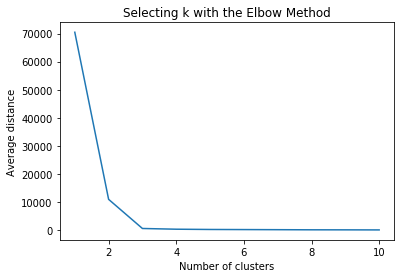

In [133]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import collections
import numpy as np
import matplotlib.pylab as plt


name_lookup = {record['player_id']:record['full_name'] for record in nba_player_stats_df[['player_id','full_name']].to_dict('records')}
clusters=range(1,11)
meandist = []

for k in clusters:
    train_set = nbapstatsdfkmeans
    model = KMeans(n_clusters=k)
    model.fit(train_set)
    model.predict(train_set)
    meandist.append(sum(np.min(cdist(train_set, model.cluster_centers_, 'euclidean'), axis=1)) / train_set.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')



# With 3 clusters, let's see which players are in the cluster
model = KMeans(n_clusters=3)
model.fit(train_set)

clustering = collections.defaultdict(list)


for idx, label in enumerate(model.labels_):
    clustering[label].append(idx)



for cluster in clustering:
    print("Cluster: %d"%(cluster))
    player_cluster = nbapstatsdfkmeans[nbapstatsdfkmeans.index.isin(clustering[cluster])][['player_id']]
    player_cluster.name = player_cluster.player_id.apply(lambda x : name_lookup[x])
    print(player_cluster.name)
    
